In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
tickers = ['JPM', 'BAC', 'XOM', 'CVX', 'AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN', 'NFLX']
data = yf.download(tickers, start="2018-01-01", end="2024-01-01")['Adj Close']

[*********************100%***********************]  10 of 10 completed


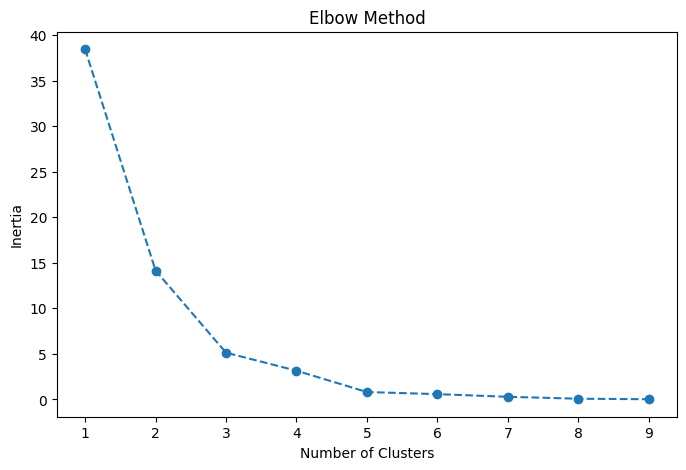

In [22]:
# Elbow Method for number of clusters

inertia = []
cluster_range = range(1, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


[*********************100%***********************]  1 of 1 completed


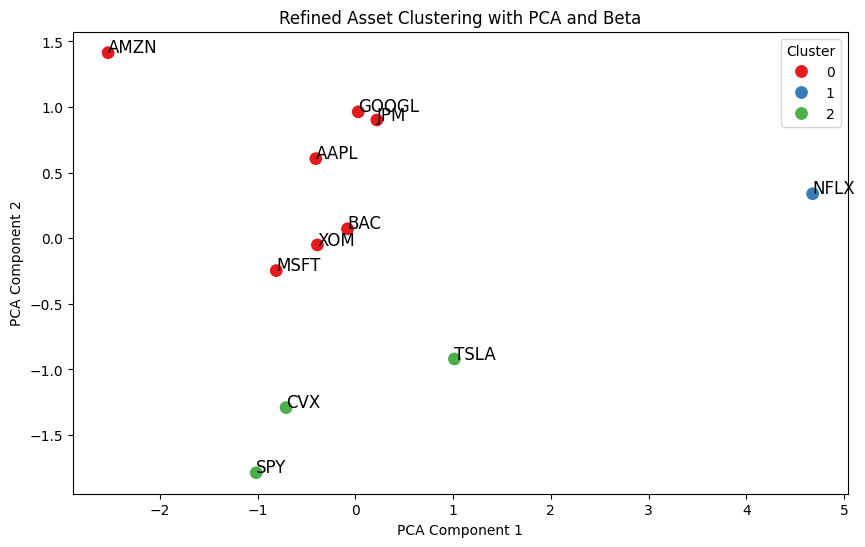

In [29]:
returns = data.pct_change().dropna()

volatility = returns.rolling(window=30).std().dropna()

# Beta - correlation to market - (SPY)
spy_data = yf.download('SPY', start="2018-01-01", end="2024-01-01")['Adj Close']
spy_returns = spy_data.pct_change().dropna()
beta = returns.apply(lambda x: np.cov(x, spy_returns)[0, 1] / np.var(spy_returns))

rolling_corr = returns.rolling(window=30).corr().groupby(level=1).mean()

features = pd.DataFrame({
    'mean_return': returns.mean(),
    'volatility': volatility.mean(),
    'beta': beta,
    'rolling_corr_mean': rolling_corr.mean(axis=1)
})

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA for dimensionality reduction
# https://medium.com/@sayahfares19/principal-component-analysis-pca-with-scikit-learn-2ed4452805c9#:~:text=In%20general%2C%20PCA%20is%3A,most%20variance%20in%20your%20data.
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_features)

features['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=features['Cluster'], palette='Set1', s=100)
for i, ticker in enumerate(tickers):
    plt.text(pca_features[i, 0], pca_features[i, 1], ticker, fontsize=12)
plt.title('Refined Asset Clustering with PCA and Beta')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## This is isn't the best approach to find linked assets. While K Means Clustering may be a great tool for this, the choice of features needs to be more researched.